# Algorytm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from itertools import accumulate
from random import randint, seed

from IPython import display

In [ ]:
def mutation(pop, tau, tau0, beta, dims, domain, init_domain):
    xs, sigmas, alphas = pop[:, 0], pop[:, 1], pop[:, 2]
    mutated = []
    for i in range(len(pop)):
        eps0 = np.random.normal(0, tau0)
        eps = np.random.normal(0, tau, size=dims)

        sigma = sigmas[i] * np.exp(eps0 + eps)
        alpha = alphas[i] + np.random.normal(0, beta, size=dims)
        z = np.random.normal(0, sigma, size=dims)
        T = np.identity(dims)
        for p in range(1, dims):
            for q in range(p+1, dims):
                j = (int(0.5*(2*dims-p)*(p+1) - 2*dims + q) - 1) % dims
                Tpq = np.zeros((dims, dims), float)
                np.fill_diagonal(Tpq, 1)
                Tpq[p,q], Tpq[q,p], Tpq[q,q], Tpq[p,p] = -np.sin(alpha[j]), np.sin(alpha[j]), np.cos(alpha[j]), np.cos(alpha[j])
                T *= Tpq*alpha[j]
        e = np.dot(T,np.transpose(z))
        x = xs[i] + e
        mutated.append(np.vstack((x, sigma, alpha)))

    return np.array(mutated)


def recombination(pop):
    mutated = []
    for _ in range(len(pop)):
        u = np.random.rand()
        while u == 0:
            u = np.random.rand()
        k1, k2 = pop[np.random.randint(pop.shape[0], size=2), :]
        x = u*k1[0] + (1-u)*k2[0]
        sigma = u*k1[1] + (1-u)*k2[1]
        alpha = u*k1[2] + (1-u)*k2[2]
        mutated.append(np.vstack((x, sigma, alpha)))

    return np.array(mutated)


def mixed_mutation(pop, tau, tau0, beta, dims, domain, init_domain):
    l = int(len(pop)/2)
    p1, p2 = pop[:l,:], pop[l:,:]
    return np.vstack((mutation(p1, tau, tau0, beta, dims, domain, init_domain), recombination(p2)))


def roulette(pop, costs, offspring_size):
    if min(costs) == max(costs):
        idxs = np.random.choice(len(pop), size=offspring_size, replace=True)
    else:
        std_costs = (costs - min(costs)) / (costs - min(costs)).max()
        p_costs = (1 - std_costs)
        idxs = np.random.choice(len(pop), p=p_costs / sum(p_costs), size=offspring_size, replace=True)
    return pop[idxs].copy()


def Mulambda(pop, pop_costs, children, children_costs, pop_size):
    full_pop = np.vstack((pop, children))
    full_costs = np.append(pop_costs, children_costs)
    idxs = np.argsort(full_costs)[:pop_size]
    return full_pop[idxs], full_costs[idxs]


def on_segment(p1, p2, q1):
    return q1[0] <= max(p1[0], p2[0]) and q1[0] >= min(p1[0], p2[0]) and q1[1] <= max(p1[1], p2[1]) and q1[1] >= min(p1[1], p2[1])


def orientation(p1, p2, p3):
    check = (float(p2[1] - p1[1]) * (p3[0] - p2[0])) - (float(p2[0] - p1[0]) * (p3[1] - p2[1]))
    if check == 0:
        return 0
    if check > 0:
        return 1
    return 2


def is_collision(p1, p2, q1, q2):
    o1 = orientation(p1, p2, q1)
    o2 = orientation(p1, p2, q2)
    o3 = orientation(q1, q2, p1)
    o4 = orientation(q1, q2, p2)
  
    if ((o1 != o2) and (o3 != o4)):
        return True
    if ((o1 == 0) and on_segment(p1, p2, q1)):
        return True  
    if ((o2 == 0) and on_segment(p1, q2, q1)):
        return True
    if ((o3 == 0) and on_segment(p2, p1, q2)):
        return True
    if ((o4 == 0) and on_segment(p2, q1, q2)):
        return True
    return False

In [ ]:
def IK(domain, dims, dest, l, blocks, cost_func, tau, tau0, beta, tweak=0, block_tweak=[[0,0],0], population_size=1000, offspring_size=500, parent_function=roulette, mutation_function=mutation, replacement_method=Mulambda, init_domain=None, max_iter=1000, visualize=False):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    init_domain = np.array([init_domain] * dims)
    domain = np.array([domain] * dims)
    sign = -1
    blocker = block_tweak[1]

    pop = []
    for _ in range(population_size):
        pop.append(np.vstack((np.random.uniform(init_domain[:,0], init_domain[:,1], size=dims), np.random.uniform(0.5, 2, size=dims), np.random.uniform(0.5, 2, size=dims))))
    pop = np.array(pop)

    costs = cost_func(pop, dest, blocks)
    best_ind, best_cost = pop[np.argmin(costs)], costs.min()

    for i in range(max_iter):

        if tweak != 0:
            for e in dest:
                r = randint(1, 10)
                if r % 2:
                    dest[dest==e] += tweak * r
                else:
                    dest[dest==e] -= tweak * r
            best_cost = cost_func(np.array([best_ind]), dest, blocks).min()
            costs = cost_func(pop, dest, blocks)

        if block_tweak[1] != 0:
            if blocker == 0:
                blocker = block_tweak[1]
                sign *= -1
            for block in blocks:
                block[0][0] += block_tweak[0][0] * sign
                block[0][1] += block_tweak[0][1] * sign
                block[1][0] += block_tweak[0][0] * sign
                block[1][1] += block_tweak[0][1] * sign
            blocker -= 1
            best_cost = cost_func(np.array([best_ind]), dest, blocks).min()
            costs = cost_func(pop, dest, blocks)

        parents = parent_function(pop, costs, offspring_size)[:, :]
        children = mutation_function(parents, tau, tau0, beta, dims, domain, init_domain)
        c_costs = cost_func(children, dest, blocks)
        pop, costs = replacement_method(pop, costs, children, c_costs, population_size)

        if costs.min() < best_cost:
            best_cost = costs.min()
            best_ind = pop[np.argmin(costs)]
        
            if visualize:
                ax.clear()
                s = np.array([0, 0])
                ax.scatter(0, 0, c='black', s=100)
                ax.scatter(dest[1], dest[0], c='grey', s=100)
                s_angs = 0
                for i, ang in enumerate(best_ind[0]):
                    s_angs += ang
                    e = s + np.array([l[i]*np.sin(s_angs), l[i]*np.cos(s_angs)])
                    ax.plot([s[1], e[1]], [s[0], e[0]], c='black')
                    s = e
                    ax.scatter(s[1], s[0], c='black', s=30)
                for block in blocks:
                    ax.plot([block[0][1], block[1][1]], [block[0][0], block[1][0]], c='red')
                ax.axis('equal')
                display.display(fig)
                display.clear_output(wait=True)

    plt.close()
    print(f"cost: {best_cost}")
    return best_ind, best_cost, dest

In [ ]:
def cost_func(pop, l, dest, blocks):
    res = np.zeros(len(pop))
    for i, angles in enumerate(pop[:,0]):
        angles = list(accumulate(angles))
        p = np.array([sum(l*np.sin(angles)), sum(l*np.cos(angles))])
        res[i] = np.sqrt(((p-dest)**2).sum())
    return res


def cost_func2(pop, l, dest, blocks):
    res = np.zeros(len(pop))
    for i, angles in enumerate(pop[:,0]):
        angles = list(accumulate(angles))
        xs = list(accumulate(l*np.sin(angles)))
        ys = list(accumulate(l*np.cos(angles)))
        xs.insert(0, 0.0)
        ys.insert(0, 0.0)
        p = np.array([sum(l*np.sin(angles)), sum(l*np.cos(angles))])
        res[i] = np.sqrt(((p-dest)**2).sum())*5*len(l)/2

        for j in range(len(xs)-1):
            for block in blocks:
                if is_collision([ys[j], xs[j]], [ys[j+1], xs[j+1]], [block[0][1], block[0][0]], [block[1][1], block[1][0]]):
                    res[i] = res[i] + (len(xs)-j)*10
    return res


# Testy

In [ ]:
def draw(ind, l, dest, blocks):
    plt.figure()
    s = np.array([0, 0])
    plt.scatter(0, 0, c='black', s=100)
    plt.scatter(dest[1], dest[0], c='grey', s=100)
    s_angs = 0
    for i, ang in enumerate(ind[0]):
        s_angs += ang
        e = s + np.array([l[i]*np.sin(s_angs), l[i]*np.cos(s_angs)])
        plt.plot([s[1], e[1]], [s[0], e[0]], c='black')
        s = e
        plt.scatter(s[1], s[0], c='black', s=30)
    for block in blocks:
        plt.plot([block[0][1], block[1][1]], [block[0][0], block[1][0]], c='red')
    plt.axis('equal')
    plt.show()

## Ustawienia

In [ ]:
def inverse_kin(l, dest, domain=(-2*np.pi, 2*np.pi), max_iter=100, tweak=0, blocks=[], block_tweak=[[0,0],0], cost_func=cost_func, mutation_function=mutation, population_size=1000, offspring_size=500, visualize=False):
    d = len(l)
    
    np.random.seed(42)
    seed(42)
    
    tau, tau0, beta = 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 1/np.sqrt(d)
    ind, cost, dest = IK(domain=domain, dims=d, dest=dest, l=l, tweak=tweak, blocks=blocks, block_tweak=block_tweak, population_size=population_size, offspring_size=offspring_size, cost_func=lambda pop, dest, blocks: cost_func(pop, l, dest, blocks), mutation_function=mutation_function, tau=tau, tau0=tau0, beta=beta, init_domain=(max(domain[0], 0), min(domain[1], 2*np.pi)), max_iter=max_iter, visualize=visualize)

    draw(ind, l, dest, blocks)
    print(f'best: {ind},\ndest: {dest}')

## Nieruchomy cel

cost: 0.0271269060584237


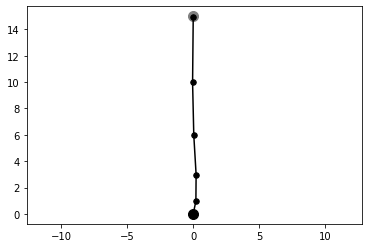

best: [[ 7.65083543  0.19459646  0.06750952  6.24699483  6.25060386]
 [ 0.05842613  0.20547824  0.18390833  0.03198746  0.08844294]
 [-0.57763726  0.84307165  1.14170024 -0.02955484  0.67328797]],
dest: [15  0]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5]), np.array([15, 0]))

cost: 0.0271269060584237


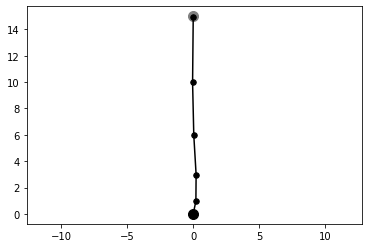

best: [[ 7.65083543  0.19459646  0.06750952  6.24699483  6.25060386]
 [ 0.05842613  0.20547824  0.18390833  0.03198746  0.08844294]
 [-0.57763726  0.84307165  1.14170024 -0.02955484  0.67328797]],
dest: [15  0]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5]), np.array([15, 0]), visualize=True)

cost: 1.0053975831199957


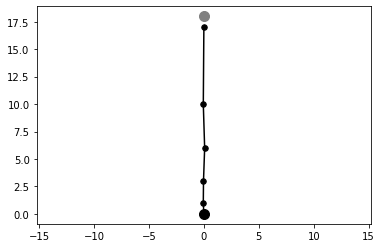

best: [[ 1.62315741  6.22163968 -0.02596538  0.06598131 -0.03817022]
 [ 0.01498571  0.48820555  0.25007672  0.03367399  0.72063589]
 [ 0.19950381  0.33974876 -0.1371327   1.32191706  1.74013518]],
dest: [18  0]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 7]), np.array([18, 0]))

cost: 3.0438176843468804e-10


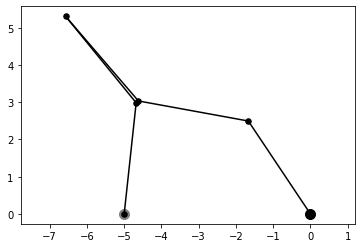

best: [[ 2.15995313e+00  8.01115048e-01  5.60330719e+00  3.11554506e+00
   5.49134122e+00]
 [ 1.20973890e-07  5.29112803e-07  1.16089014e-07  1.45177841e-07
   3.82453330e-08]
 [-3.70917437e-01  2.91897521e-01 -5.19949395e-01  9.91054219e+00
   2.82951916e-01]],
dest: [ 0 -5]


In [ ]:
inverse_kin(np.array([3, 3, 3, 3, 3]), np.array([0, -5]))

cost: 2.253979457640172e-08


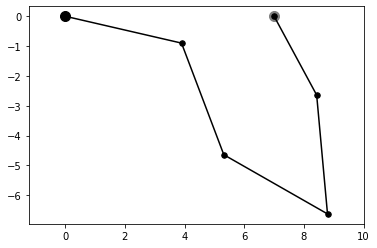

best: [[ 6.05626927e+00 -9.81658463e-01  6.89930124e-01  2.18040269e+00
   4.04188367e-01]
 [ 1.00022161e-05  5.16709511e-06  4.19638086e-05  4.43276327e-05
   3.24867285e-06]
 [-6.32113094e-01 -1.14499423e-02  3.24198100e-01  2.83268532e+00
   1.67843609e-01]],
dest: [0 7]


In [ ]:
inverse_kin(np.array([4, 4, 4, 4, 3]), np.array([0, 7]), domain=(-np.pi*5/6, 0))

l: [15 48 91 98 99 68 83 52 57 78 10 56 34 99 46 53 83 37 38 89 51 90 86 69
 69 99 42 93 35  1 80 73 77 66 80 34 47 86 99 15 81 49  1 61 18 16 19 21
 25 82],
dest: [483.16666667 483.16666667]
domain: (-0.42*pi, 1.67*pi)
cost: 7.5808024619825085


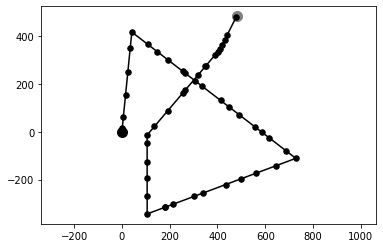

best: [[-5.29169788e+31 -5.21103664e+12 -3.54168529e+13  1.96078074e+12
   1.15764657e+11  2.97330349e+13  5.01763380e+15 -1.38142111e+12
  -1.10437851e+10  4.55381181e+09 -4.02580885e+13  2.81274170e+15
  -9.39405116e+11  5.72338354e+11  9.10330505e+12 -5.84804863e+10
  -3.63238648e+11 -3.36320401e+13 -1.14385630e+12 -2.19224968e+10
   8.12235217e+12  8.66567999e+15 -1.95131902e+12 -9.45618605e+09
   1.23651958e+11 -2.34648941e+14 -1.45487475e+11  3.81320219e+13
  -1.35736014e+15 -4.45768631e+15  7.46010221e+10 -4.31097780e+16
   4.83793901e+14  1.49320258e+11  2.06349999e+08  7.17241837e+10
   1.55106193e+19  2.14665105e+12  1.37188531e+10 -8.70233457e+13
   3.75354526e+07  1.62040885e+13  2.83417811e+11  1.71596743e+12
  -2.09951894e+10  1.51303511e+15 -1.92981995e+20 -1.30931589e+08
  -1.45514122e+10 -2.20232608e+13]
 [ 8.42846315e+00  2.35049523e+01  9.79444610e+00  4.50779028e+00
   1.74245416e+01  1.13559529e+01  1.91263264e+01  3.12298268e+01
   6.96165308e+00  4.70027526e+00  

In [ ]:
l = np.random.randint(100, size=50)+1
dest = np.array([l.sum()*randint(1, 5)/6, l.sum()*randint(1, 5)/6])
domain = (round(np.random.uniform(-2, 0),2)*np.pi, round(np.random.uniform(0, 2),2)*np.pi)
print(f"l: {l},\ndest: {dest}\ndomain: ({domain[0]/np.pi}*pi, {domain[1]/np.pi}*pi)")
inverse_kin(l, dest, domain=domain, max_iter=200)

## Ruszający się cel

cost: 0.0841406102990653


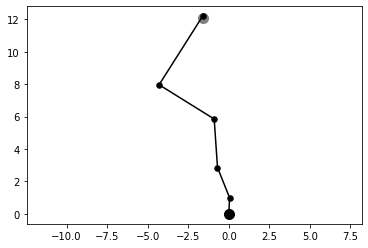

best: [[ 1.52130373  0.43150643  5.96892289  0.94626837  4.70351963]
 [ 0.10021645  0.61212807  0.16628672  0.01357962  0.83438656]
 [ 1.05884294  1.36939902  0.98308785  0.83497319 -1.18826765]],
dest: [12.1 -1.6]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5]), np.array([15.0, 0.0]), tweak=0.1)

cost: 0.0841406102990653


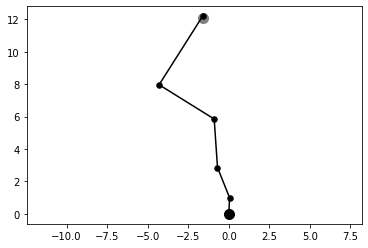

best: [[ 1.52130373  0.43150643  5.96892289  0.94626837  4.70351963]
 [ 0.10021645  0.61212807  0.16628672  0.01357962  0.83438656]
 [ 1.05884294  1.36939902  0.98308785  0.83497319 -1.18826765]],
dest: [12.1 -1.6]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5]), np.array([15.0, 0.0]), tweak=0.1, visualize=True)

cost: 0.0036432713086737567


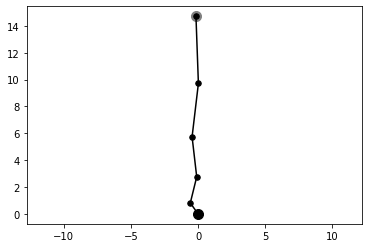

best: [[ 2.1883407   5.42492926  0.35567836  6.05053048  6.43716264]
 [ 1.39168365  0.71521074  1.61326575  3.0349335   2.5005403 ]
 [ 4.20611457  0.75651264 -0.0675017   2.42353945  0.45541658]],
dest: [14.71 -0.16]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5]), np.array([15.0, 0.0]), tweak=0.01)

cost: 0.0018180788226327379


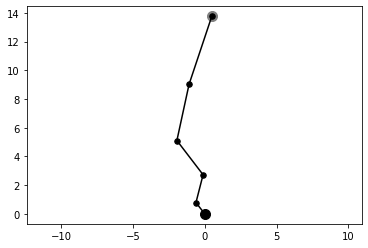

best: [[ 2.23060137e+00  5.37318737e+00  9.03446974e-01  5.41666499e+00
   6.17397288e+00]
 [ 2.49536772e-02  7.12079785e-03  1.44453508e-02  2.74985822e-02
   5.10062130e-03]
 [ 2.12266571e+00 -2.73914740e+00  4.32574454e-02 -1.26194691e+00
  -4.58101083e-01]],
dest: [13.76  0.49]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5]), np.array([15.0, 0.0]), tweak=0.01, max_iter=200)

cost: 5.208043579404533e-09


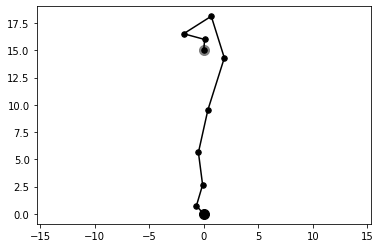

best: [[ 2.30391453  5.26133607  0.41726189  5.93549549  6.19639253  0.61021704
   1.83132361  2.31261429  4.88692226]
 [ 0.43581703  1.69588524  6.00505747  0.21057366  0.15781578 13.28184499
   0.24128611 21.78275551 20.24948588]
 [ 0.20550433  0.14304188 -0.0718082   0.58494036 -0.97447293  2.607435
  -0.55813564  6.6563754  -1.00620278]],
dest: [15.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 2, 1]), np.array([15.0, 0.0]))

cost: 0.17952417019547634


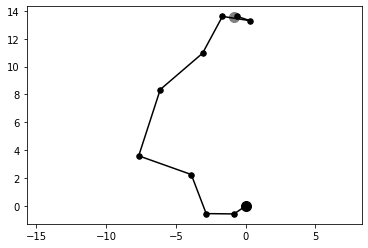

best: [[ 8.89672921e+02  5.66967730e+00  5.08848177e+00  8.64322286e-01
   4.74001056e+00  5.73568276e+00  3.67181071e-01  5.05296534e+00
   2.97238120e+00]
 [ 1.50631143e+00  1.20778220e+00  1.83693727e+00  2.97379179e+00
   1.98588728e+01  1.70850226e-01  9.04882649e+00  1.03247619e+01
   8.32017976e-01]
 [ 3.78493019e-01 -1.07060222e+00  8.04989641e-01  3.87254466e-01
  -9.49647579e-01  2.53924194e+00  2.17113986e+00 -1.77614549e+00
  -1.00600795e+00]],
dest: [13.55 -0.8 ]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 2, 1]), np.array([15.0, 0.0]), tweak=0.05)

cost: 0.02758524666761201


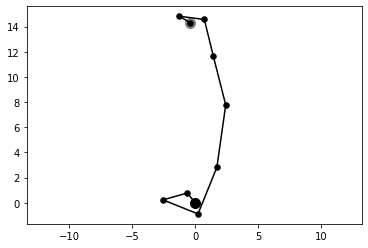

best: [[ 2.26216767  1.1535026   2.48621334  1.56789327  0.24321574  0.39054188
  -0.01029264  1.20372382  2.72902769]
 [ 0.02754618  0.15683837  0.88955531  0.05255304  0.00826435  0.27437478
   2.19858312  0.21230871  0.91836408]
 [-0.17875385 -2.62614054  1.06366098 -0.27273842  3.09869041 -3.06772864
   1.29892827  1.38952654  0.46029093]],
dest: [14.275 -0.4  ]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 2, 1]), np.array([15.0, 0.0]), tweak=0.025, domain=(-np.pi, np.pi))

cost: 0.017732870199281266


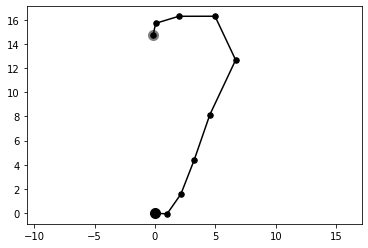

best: [[-0.06385478  1.02438075  0.23831755  0.03891835 -0.10768734  0.88164679
   1.13123153  0.29386615  1.06869977]
 [ 1.38852214  0.28914842  3.15188526  0.43308701  0.25558203  0.17704445
   0.03304662  0.04936273  0.06036508]
 [-1.85785053  0.81570877  0.03903036 -1.77584651 -0.46163024 -0.35157764
   1.43775936  2.03068257  1.93188868]],
dest: [14.71 -0.16]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 2, 1]), np.array([15.0, 0.0]), tweak=0.01, domain=(-np.pi/2, np.pi/2))

cost: 0.0072640813024668835


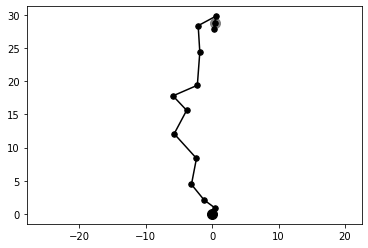

best: [[ 6.39954201e+04  1.32812719e+00  6.03128981e+00  5.40969377e+00
   9.27204707e-01  5.05698974e+00  1.24614072e+00  4.36505405e+00
   1.08693909e+00  1.35855391e-01  5.14371877e+00  4.08790841e+00
   3.05919429e+00]
 [ 2.50064721e-01  1.78557427e-01  1.34270725e+00  3.17571389e+00
   1.36658917e+00  1.45309355e-01  1.38593845e-01  3.79706843e-02
   1.50156775e+00  2.34316175e+00  7.48528138e-02  1.00071827e-01
   1.91055746e-01]
 [ 7.88709677e-01 -3.68136024e+00  4.99278109e+00 -3.38111142e+00
   7.92880874e-01  4.02281859e-01  3.58566885e+00 -1.74784270e-01
  -3.82508606e-02 -1.01534008e+00 -1.43319049e+00 -5.89791252e-01
   3.62618136e+00]],
dest: [28.76  0.49]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 4, 5, 4, 3, 2, 1]), np.array([30.0, 0.0]), tweak=0.01, max_iter=200)

cost: 0.0051010327993223975


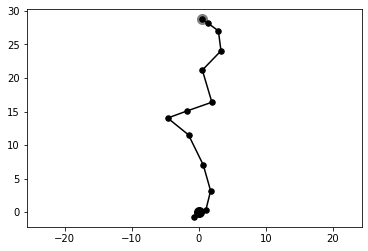

best: [[-2.42767350e+07  4.68248384e+01  2.58426217e+02  1.57597090e+02
  -5.17088202e+03  1.70080367e+02  6.70060266e+01 -1.06815574e+03
  -3.06354279e+02  1.81154503e+02  3.23157600e+01  1.16947500e+03
   3.95898797e+02]
 [ 2.14895130e+01  8.77313562e+00  2.20815342e+00  3.69829523e+01
   2.05230301e+01  2.97500837e+01  4.86109526e+02  1.22611062e+02
   1.11026042e+01  1.79111524e+01  1.38624474e+01  8.92964444e+00
   3.30830416e+02]
 [ 1.44963119e-01  3.08661433e+00  4.31604545e-01  7.44638019e-01
   1.01928505e+00  3.29778524e+00  6.91433200e-02  6.35645798e-01
  -5.90097669e-01  5.39060904e+00 -8.94485256e-01  2.68599010e+00
   8.41563704e-01]],
dest: [28.76  0.49]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 4, 5, 4, 3, 2, 1]), np.array([30.0, 0.0]), tweak=0.01, domain=(0, np.pi), max_iter=200)

cost: 4.22158336812463


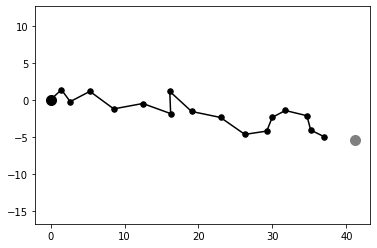

best: [[ 4.38705735e+10 -9.56722284e+02 -1.09185900e+03  4.43481387e+03
   9.81515213e+03  8.14860995e+04 -4.54078634e+03 -1.16827937e+04
  -1.38978675e+04 -1.73491717e+05  6.03944153e+02 -6.17912694e+01
   1.96405301e+04  1.42683930e+04  1.63289219e+04 -2.06631271e+03]
 [ 2.71931853e-01  6.97470080e-01  1.63089033e+01  1.58462141e+01
   7.98674491e-03  1.87584563e-01  9.79427341e-02  2.51601936e-01
   1.00478730e-01  1.33382835e+00  5.49580026e-01  2.96677448e-01
   1.46844520e+00  3.13840084e-01  1.78545702e-01  2.63735649e-01]
 [ 7.80520679e-01 -3.09011806e-01  3.09279574e+00  4.73012621e-01
   5.21648641e-01  2.08701048e+00 -8.88145492e-01  6.23412387e+00
   1.89796411e+00  1.14265585e+00 -4.79129960e-01  4.65481100e+00
   1.97559901e+00 -3.16760113e-02  5.22862651e+00 -3.41813731e-01]],
dest: [-5.5  41.15]


In [ ]:
inverse_kin(np.array([2, 2, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 2, 3, 2, 2]), np.array([0.0, 40.0]), tweak=0.05, domain=(0, np.pi), max_iter=150)

cost: 427.2822927791893


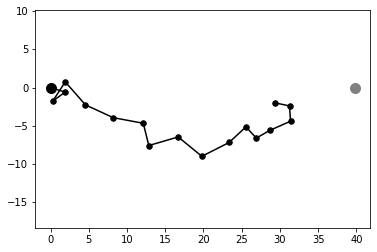

best: [[-6.74174119e+11 -1.59288153e+02 -1.28438334e+02  4.43800655e+00
   4.18721159e-01  2.47010520e-01 -7.42535756e+00  7.89458538e+00
   2.37791920e+02  1.15411108e+00  1.07094553e+02 -5.81246154e+01
   1.34744151e+00 -1.05888442e-01  1.22389010e+00  7.57145986e+00]
 [ 1.21365189e+00  1.99883326e+00  1.40132275e+00  3.78348235e+00
   1.68832361e+00  3.26054612e+00  2.04710467e+00  2.35498913e+00
   2.31644961e+00  2.23390620e+00  3.19649774e+00  1.30008826e+00
   8.65182964e-01  5.14558273e+00  1.87146256e+00  2.04520970e+00]
 [ 1.23447288e+00  1.40129636e+00  1.23426441e+00  1.30688617e+00
   4.60117760e-01  7.89775104e-01  1.22410644e+00  1.08665907e+00
   2.35664919e-01  1.24531237e+00  2.28420691e+00  9.80772051e-01
   1.27756191e+00  3.65372687e-01  1.23435340e+00  1.34798095e+00]],
dest: [-0.05 39.8 ]


In [ ]:
inverse_kin(np.array([2, 2, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 2, 3, 2, 2]), np.array([0.0, 40.0]), tweak=0.05, domain=(0, np.pi), mutation_function=mixed_mutation, cost_func=cost_func2, max_iter=20)

cost: 0.010125732797849788


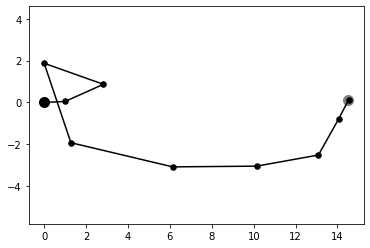

best: [[4.98189096e-02 3.71883807e-01 2.37897297e+00 2.23608692e+00
  1.01344488e+00 2.41673916e-01 1.69066131e-01 8.81808026e-01
  3.28999576e-02]
 [9.04553053e+00 2.20931169e+01 7.39057485e+00 2.20003036e+01
  1.56625072e+02 8.20543807e-01 2.15906863e+02 8.73723218e+00
  5.05859391e+00]
 [5.95748842e-01 1.89462792e-01 9.38087211e-02 2.27710026e+00
  5.50793317e-01 3.45541388e+00 2.78749002e+00 4.04485173e+00
  6.06049689e-01]],
dest: [ 0.13 14.52]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 2, 1]), np.array([1.0, 15.0]), tweak=0.03, domain=(0, np.pi))

l: [ 58  52  84  37   6  62  73  29   7  98  61   7  54  57  46  45  67  96
  37  93  80  87  74  78  12  50  23  70  46  26  96  21  65  93  78  28
  59  43 100  69  25  29  85  35  79  84  88   2  82  96],
dest: [1436.          957.33333333]
tweak: 0.021520550270693425
domain: (-0.28*pi, 0.81*pi)
cost: 54.247966325262304


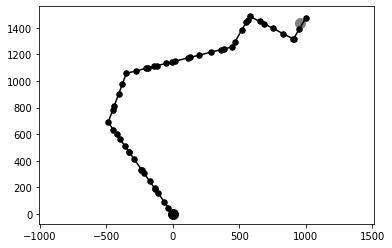

best: [[ 2.29053789e+63  8.03811965e+41 -2.46309671e+42  2.72365249e+40
  -6.55771273e+37  4.05074969e+40  2.47365381e+38  6.66071260e+39
   2.76223864e+40  2.76161652e+39  1.04281663e+45 -1.45586267e+40
   4.84707412e+40 -4.32091052e+38 -1.25919671e+40  4.35255122e+38
  -1.56266941e+39 -6.29919358e+47 -7.39147174e+38  2.73737686e+34
   2.46222374e+43 -3.58435376e+40 -6.46320037e+47 -3.39283539e+33
   1.79443155e+39  4.51572053e+39 -7.11206839e+43  1.29870180e+42
  -9.10414774e+43 -2.24875344e+33 -3.46840293e+46 -3.09128708e+33
  -2.37876703e+44 -7.97346694e+40 -1.30511796e+37  2.57575731e+45
   1.02357967e+44  1.61449667e+50  1.16818230e+33 -9.05304415e+34
  -1.89998324e+44 -9.97435623e+36 -2.73170785e+51  1.34862635e+39
  -2.78559654e+32 -3.61532579e+45  2.11594269e+45 -2.28323539e+50
   8.41456857e+35 -2.62935118e+35]
 [ 2.56385953e+00  1.98087405e+00  3.19261138e+00  2.48383107e+00
   3.11450169e+00  2.01663670e+00  5.64715889e+00  1.41019197e+00
   4.04014790e+00  4.38537172e+00  

In [ ]:
l = np.random.randint(100, size=50)+1
# dest = np.array([l.sum()*randint(1, 5)/6, l.sum()*randint(1, 5)/6])
dest = np.array([l.sum()*3/6, l.sum()*2/6])
tweak = np.random.uniform(0.0,0.05)
domain = (round(np.random.uniform(-2, 0),2)*np.pi, round(np.random.uniform(0, 2),2)*np.pi)
print(f"l: {l},\ndest: {dest}\ntweak: {tweak}\ndomain: ({domain[0]/np.pi}*pi, {domain[1]/np.pi}*pi)")
inverse_kin(l, dest, tweak=tweak, domain=domain, max_iter=200)

## Blok stojacy

cost: 1.0371224174390304e-06


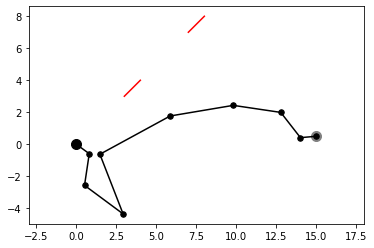

best: [[ 5.65335849  5.19362001  1.0820383   2.57940487  4.83994034  5.9511126
   5.96930887  5.52126404  0.99582024]
 [ 0.45636404  0.77327714  2.18233829  1.7968064   2.556787    1.53200907
   4.38505516  4.37654955  0.40571648]
 [ 0.90576075 -0.16924499  0.72376029  0.13441876  3.13791166  4.62077876
  -0.06844587  1.37600953  0.03266653]],
dest: [ 0.5 15. ]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 2, 1]), np.array([0.5, 15.0]), blocks=[[[3, 3],[4, 4]], [[7, 7],[8, 8]]], cost_func=cost_func2)

cost: 0.0005973627056610177


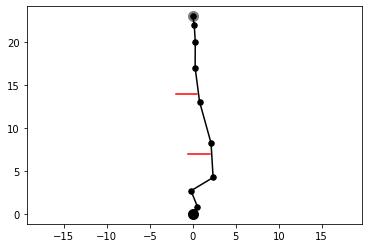

best: [[-5.26791701e+02  9.59644288e-01  4.86956357e+00  1.08829371e+00
   2.11322385e-01  6.14192189e+00 -1.88630601e+02  6.76249187e-02
   5.34174920e+02]
 [ 4.29502207e-01  9.65168915e-01  1.21901106e+00  1.46748676e+00
   1.03978044e+00  2.75589785e-01  1.94617648e+00  8.32910567e-01
   2.35783330e-01]
 [ 1.08006640e+00  3.87579812e+00  1.91159714e+00  1.60957861e+00
   3.17886173e+00  1.10285380e+00  9.93601455e-02  1.07671232e+00
  -5.05445055e-02]],
dest: [23.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 2, 1]), np.array([23.0, 0.0]), blocks=[[[7, -0.5],[7, 2]], [[14, -2],[14, 0.5]]], cost_func=cost_func2, mutation_function=mixed_mutation)

cost: 0.0005973627056610177


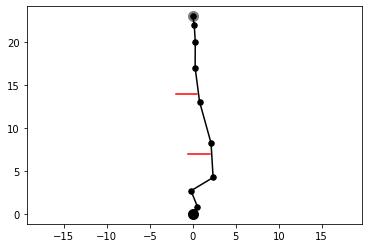

best: [[-5.26791701e+02  9.59644288e-01  4.86956357e+00  1.08829371e+00
   2.11322385e-01  6.14192189e+00 -1.88630601e+02  6.76249187e-02
   5.34174920e+02]
 [ 4.29502207e-01  9.65168915e-01  1.21901106e+00  1.46748676e+00
   1.03978044e+00  2.75589785e-01  1.94617648e+00  8.32910567e-01
   2.35783330e-01]
 [ 1.08006640e+00  3.87579812e+00  1.91159714e+00  1.60957861e+00
   3.17886173e+00  1.10285380e+00  9.93601455e-02  1.07671232e+00
  -5.05445055e-02]],
dest: [23.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 2, 1]), np.array([23.0, 0.0]), blocks=[[[7, -0.5],[7, 2]], [[14, -2],[14, 0.5]]], cost_func=cost_func2, mutation_function=mixed_mutation, visualize=True)

cost: 5.947109932837513e-07


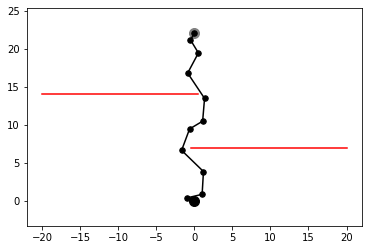

best: [[ 5.30116489e+01  3.77140721e+00  1.27810725e+00  8.59618060e-01
   5.12450407e+00  5.60941866e+00  9.47085592e-01  6.72610418e-01
   5.20464593e+00  1.03638478e+00  5.20518307e+00]
 [ 1.93189220e+00  3.16653232e+01  4.60406439e+00  1.00579317e+01
   2.46018785e+00  5.99923786e-01  1.79629546e+01  5.04914140e+00
   1.07787477e+00  3.09310505e+00  4.12110015e-01]
 [-6.32810574e-01 -5.15064831e-02 -1.66779797e-02  4.12293338e+00
   1.06094971e+00  2.54326847e+00 -7.70827773e-02  4.08483171e-01
   1.59847004e+00  2.33007037e+00  8.67127430e-01]],
dest: [22.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 1]), np.array([22.0, 0.0]), blocks=[[[7, -0.5],[7, 20]], [[14, -20],[14, 0.5]]], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1000, max_iter=150)

cost: 80.0


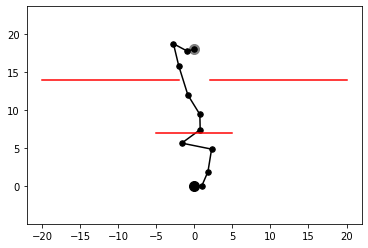

best: [[ 0.10302977  1.05988209  0.24783016  1.53201671  3.9722151   0.96001786
   0.53194762  6.03398792  6.21405579  3.98741044  0.68396273]
 [ 8.41214301  9.17625349  1.92663087 12.18576374  4.41547698 18.86006619
  10.60424112 10.66980111  7.79697794  4.09630646 13.46441561]
 [ 0.68336159  0.24530111  0.32442699 -0.33324807  2.43975889  0.88935979
   0.07890035  0.35237861 -0.22148258  2.30168186  0.61351462]],
dest: [18.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 1]), np.array([18.0, 0.0]), blocks=[[[7, -5.0],[7, 5]], [[14, -20],[14, -2]], [[14, 20],[14, 2]]], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1000, max_iter=200)

cost: 2.1262387888341813e-10


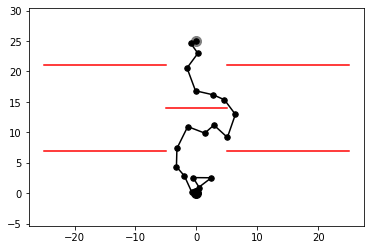

best: [[ 2.79043571e+05  1.09659965e+00  4.14905155e+00  3.80024416e+00
   4.49135640e+00  2.82235234e-01  5.54574488e+00  5.85010332e+00
   4.80609829e+00  1.08886251e+00  4.81954572e+00  1.97755349e+00
   9.77049932e-01  5.10753160e-01  1.92735161e-01  5.29318404e+00
   5.28874873e+00  1.26386036e+00  4.49837583e+00]
 [ 6.54346169e-01  6.86448609e-01  4.43825470e-01  5.36247306e-01
   1.13527817e-01  1.60609267e-01  2.26840189e+00  1.67488726e+00
   2.31161760e+00  3.61308156e-01  1.16873104e+00  7.49634145e-01
   4.62783349e+00  7.10295616e-01  4.54720872e-01  8.59230553e-02
   3.41368463e-01  5.77859678e+00  9.71692687e-01]
 [ 2.49921404e+00  3.66040379e+00  5.01682504e-01  4.73500239e+00
   2.46943536e+00 -5.63252640e-01  7.80076065e-01  3.26400836e-01
  -4.88270387e-02 -7.61358530e-01  2.87625243e+00 -1.10227929e-02
   2.11779971e-01 -2.38280386e+00 -8.32902920e-03 -2.01814224e+00
   2.18626439e+00  1.81865004e+00  1.10723750e+00]],
dest: [25.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 3, 4, 3, 2, 3, 4, 3, 2, 1]), np.array([25.0, 0.0]), blocks=[[[7, -25.0],[7, -5]], [[7, 5],[7, 25]], [[14, -5],[14, 5]], [[21, -25],[21, -5]], [[21, 5],[21, 25]]], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1500, max_iter=300)

cost: 22.05897140417655


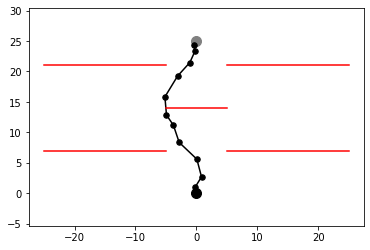

best: [[108.58755633   5.52846669   0.8100278    0.55341816   5.79685356
   12.84109311   5.77058643  -0.63402909   6.09432342   6.59237556
    6.81038602]
 [  3.5357223    9.80292887   5.85553938   0.1688311   11.23495614
    4.92729723   7.47830887   3.58568849   8.91237561   1.25555482
    1.01516819]
 [  3.87749792   0.42138792  -0.5343027    1.39002523   3.44010128
   -0.94400937   0.13805651   1.58575344   0.13486625   3.08653049
    1.71250319]],
dest: [25.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 1]), np.array([25.0, 0.0]), blocks=[[[7, -25.0],[7, -5]], [[7, 5],[7, 25]], [[14, -5],[14, 5]], [[21, -25],[21, -5]], [[21, 5],[21, 25]]], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1000, max_iter=200)

cost: 1.2891427881657349e-12


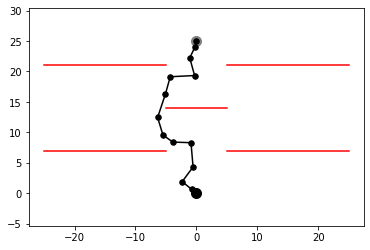

best: [[-6.38753783e+03  6.27552396e+00  4.76253851e+00  7.23422855e-01
   1.45275955e+00  5.68294005e+00 -6.43529936e-01  5.66537334e+00
  -3.13668250e+01  5.03645201e+00 -1.07784350e+01  5.57205541e+00
   1.90678061e+01]
 [ 2.26893650e-01  3.09526504e+00  1.54284840e+00  3.29306701e+00
   3.50315748e+00  3.82044006e+00  3.86184449e-01  1.57760033e+00
   6.54591546e-01  2.18148244e+00  1.59402925e+01  7.82466052e+00
   5.87883101e-01]
 [ 1.72755117e-01  4.10586393e-01  2.88819080e-01  2.52767540e-01
   3.47262352e+00  2.36062765e+00 -2.04794848e+00  2.21944848e+00
   2.15723269e-01 -2.64733635e-01  7.26443655e-02  8.88572609e-01
   1.67385751e+00]],
dest: [25.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 4, 3, 2, 1]), np.array([25.0, 0.0]), blocks=[[[7, -25.0],[7, -5]], [[7, 5],[7, 25]], [[14, -5],[14, 5]], [[21, -25],[21, -5]], [[21, 5],[21, 25]]], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1000, max_iter=220)

cost: 7.4824242964893894


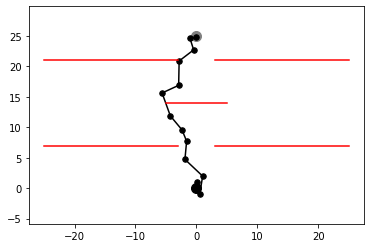

best: [[-5.87144508e+08  1.48024143e+02 -3.36503373e+02  7.25445114e+00
   1.79430545e+01 -1.67084930e+03 -2.48227146e+01  4.36337433e+01
   1.36746122e+02 -6.78258682e+04 -1.78532192e+03  3.73343676e+03
   4.55507598e+00]
 [ 1.41624298e+01  8.10814107e+00  5.39219009e+00  1.12530524e+01
   1.53394685e+02  3.68026037e+00  1.98926367e+01  4.64428805e+00
   8.37382925e+00  1.34823862e+00  1.09715761e+01  4.46227062e+00
   5.37939525e+00]
 [ 9.85249531e-02  2.52685368e+00  2.66762100e+00  3.83683773e+00
  -4.82686840e-01 -1.29058240e-01  1.67708175e+00  1.40792490e+00
   1.74591678e+00 -1.38124558e+00  2.55565432e-01  6.38962504e-01
   3.09200586e+00]],
dest: [25.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 4, 3, 2, 1]), np.array([25.0, 0.0]), blocks=[[[7, -25.0],[7, -3]], [[7, 3],[7, 25]], [[14, -5],[14, 5]], [[21, -25],[21, -3]], [[21, 3],[21, 25]]], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1000, max_iter=220)

## Blok ruchomy

cost: 19.79236437014734


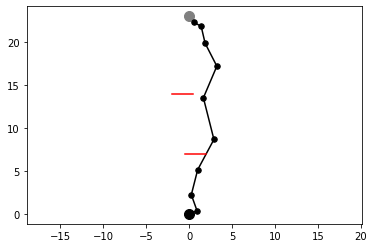

best: [[ 0.35507764  1.55863773  5.6910091   6.04019424  0.7399846  -0.65020975
   0.87577306  6.03801269  7.0930293 ]
 [ 2.23880401  6.04948185  3.33052042  5.89205164  5.98777175 24.57505536
   8.20377752 18.68445567 43.98137733]
 [ 1.06334173  0.34257792  2.97791276 -0.51822077  3.74379277  3.10653993
   0.24094761  1.66191198 -0.78557395]],
dest: [23.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 5, 4, 3, 2, 1]), np.array([23.0, 0.0]), blocks=[[[7, -0.5],[7, 2]], [[14, -2],[14, 0.5]]], block_tweak=[[0,0.5], 5], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1500, visualize=True)

cost: 1.1696570075995883e-10


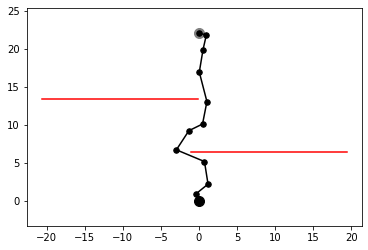

best: [[-4.3470055   5.02696231  1.04759037  1.0183314   4.52919908  5.74801347
   0.9201481   0.44734302  5.86573463 -0.0591675   1.60886755]
 [ 0.08858903  0.39834552  0.25277954  0.13110497  0.2547867   0.12369524
   0.15425239  0.120189    0.38015613  0.76461929  0.03863903]
 [ 3.26404204  0.02712495  0.17625996  2.84150238  1.2237384  -0.07184829
   1.32156176  3.5530949  -0.1832995   2.29639141 -0.00603485]],
dest: [22.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 1]), np.array([22.0, 0.0]), blocks=[[[7, -0.5],[7, 20]], [[14, -20],[14, 0.5]]], block_tweak=[[0.1,0.1], 8], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1000, max_iter=150)

cost: 3.4540526787572964e-10


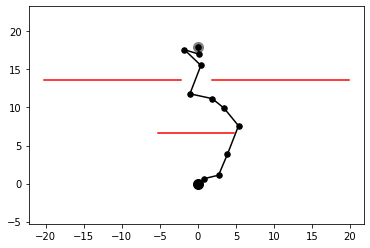

best: [[ 4.20471449e+05 -4.55332752e-01  2.60696622e+01  6.91431384e+01
   7.34162570e+00  1.27715925e+01  6.75090750e+00 -1.72772674e+00
   1.37449173e+01 -2.67801821e+00  1.15101820e+02]
 [ 2.97691665e-01  7.34716166e+00  6.57550430e-01  1.77197005e+00
   1.73502291e+00  4.48107620e+00  6.22980373e-01  6.21225181e-01
   4.50154647e-01  3.99056236e+00  3.99827969e-01]
 [ 2.89636139e+00 -1.04577197e-01  2.59425973e+00  1.05478110e-01
  -4.19240462e-03 -1.47479418e-01  1.02249908e-01  8.21965934e-01
  -1.02779290e-01 -3.07115603e-02 -1.38609752e+00]],
dest: [18.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 1]), np.array([18.0, 0.0]), blocks=[[[7, -5.0],[7, 5]], [[14, -20],[14, -2]], [[14, 20],[14, 2]]], block_tweak=[[0.2,0.1], 6], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1000, max_iter=170)

KeyboardInterrupt: ignored

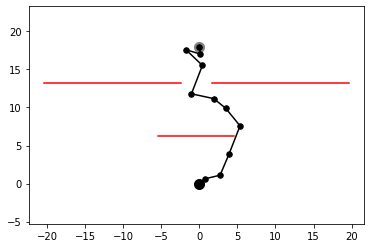

In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 1]), np.array([18.0, 0.0]), blocks=[[[7, -5.0],[7, 5]], [[14, -20],[14, -2]], [[14, 20],[14, 2]]], block_tweak=[[0.2,0.1], 6], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1000, max_iter=170, visualize=True)

cost: 4.126107046120014e-05


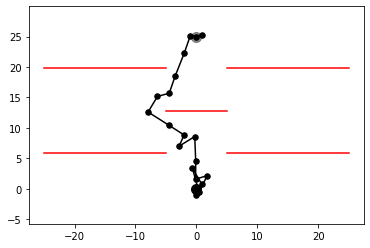

best: [[-7.48403441e+09  8.99949576e+00  1.36064367e+01  2.87662997e+00
   2.39828686e+00  2.33414865e+00 -1.18310446e+03  1.33208083e+03
   2.08480570e+00  6.90897283e+03  1.58484523e+02 -4.39740940e+01
  -9.57943942e+01  5.51160177e+00 -2.47298911e+05 -1.26127087e+01
   6.91577967e+01  5.10765028e+00  1.58394558e+01]
 [ 8.69254098e-01  1.62774154e+00  1.10034244e+00  1.85294154e+00
   6.32319451e-01  2.20314354e+01  1.85685436e+01  2.21570732e+00
   1.59809065e+00  8.62089671e-01  1.39733876e+00  1.96778505e+00
   3.03135417e+00  1.38584895e+00  6.23078561e-01  3.43990361e+00
   8.00184587e-01  9.09250510e-01  5.51810676e-01]
 [ 7.57056755e-01  3.40172616e+00  5.69427586e-01  3.46112028e+00
  -1.65234109e-01  1.16751876e+00 -6.73784762e-01  1.20466663e+00
   2.63535427e+00  3.03236757e+00  8.25008858e-01 -9.91223354e-01
   2.79430724e+00  5.97228317e-01  1.72921866e-01  9.45859784e-01
   1.24366717e+00  1.91058152e+00  1.92800623e-01]],
dest: [25.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 3, 4, 3, 2, 3, 4, 3, 2, 1]), np.array([25.0, 0.0]), tweak=0, blocks=[[[7, -25.0],[7, -5]], [[7, 5],[7, 25]], [[14, -5],[14, 5]], [[21, -25],[21, -5]], [[21, 5],[21, 25]]], block_tweak=[[0.2,0], 7], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1500, max_iter=300)

cost: 58.08941244854769


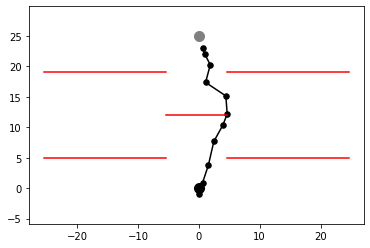

best: [[ 4.82317510e+02  9.06279285e+00 -4.06515485e-02  9.32421860e-02
   6.00374011e+00 -6.15518729e+00  4.50527858e-01  9.09330640e-01
   1.13253263e+01  7.38910078e-01 -1.18606506e-01]
 [ 2.39070558e+00  1.90275675e+00  1.53526150e+00  2.12533497e+00
   3.14185933e-01  4.32921387e+00  1.91085716e+01  6.44513000e-01
   1.16076974e-01  1.07089272e+00  2.79263937e+01]
 [-1.30076460e+00  3.64343822e+00  6.55032657e-01 -1.39982202e+00
   3.25302861e-01  8.12195722e-01  1.37742661e+00 -1.42931674e+00
  -2.06614391e-01  1.53681503e+00  1.10336583e+00]],
dest: [25.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 1]), np.array([25.0, 0.0]), blocks=[[[7, -25.0],[7, -5]], [[7, 5],[7, 25]], [[14, -5],[14, 5]], [[21, -25],[21, -5]], [[21, 5],[21, 25]]], block_tweak=[[0.5,0.1], 4], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1500, max_iter=300)

cost: 9.516140400020756


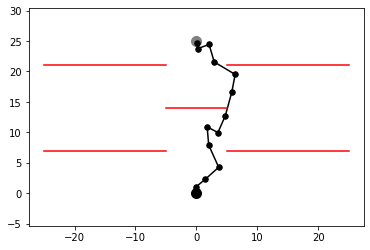

best: [[ 1.35885716e+03  5.27604252e+00  4.91594019e-02  1.26208425e+00
   5.94455057e+00  4.13964277e+00  1.64485021e+00  1.46403687e-01
   7.94253939e-02  1.22260419e+00  5.53699910e+00  1.63191559e+00
   4.43408226e+00]
 [ 1.50782555e+02  2.20371099e+03  3.56574577e+02  1.69746138e+02
   1.03399466e+02  1.00687488e+03  8.85174473e+01  3.45810609e+02
   7.81509275e+03  2.83426282e+02  1.21678372e+02  1.30061616e+03
   9.22358370e+02]
 [ 4.01165397e+00 -1.09935715e+00  1.39235225e+00  7.46437117e-01
   1.72916751e-02  1.37687466e+00 -2.20088085e-02  3.03581393e+00
   3.03075142e+00 -5.27131244e-01  6.01444198e-01 -5.66151184e-01
   2.43105398e+00]],
dest: [25.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 4, 3, 2, 1]), np.array([25.0, 0.0]), blocks=[[[7, -25.0],[7, -5]], [[7, 5],[7, 25]], [[14, -5],[14, 5]], [[21, -25],[21, -5]], [[21, 5],[21, 25]]], block_tweak=[[0.5,0.1], 5], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1000, max_iter=220)

cost: 70.00000002732224


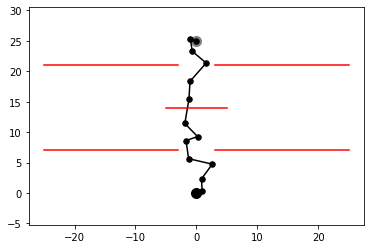

best: [[ 1.13463005e+08 -3.25420687e+02  1.81669568e+01  1.97548754e+00
   3.02089529e+01  7.40270240e+01  2.00720203e+00 -5.91560147e+02
   1.03708530e-01  3.26066344e+02  1.59491357e+00 -9.24355853e+02
   4.30933290e+00]
 [ 2.11156184e+01  1.09426627e+01  1.06135811e+01  4.02946973e+01
   2.92353038e+01  1.91942147e+01  7.97385987e+00  1.73351472e+01
   3.82720022e+01  1.37039567e+00  4.91709274e+00  1.80860980e+01
   9.22771820e+01]
 [ 3.96960474e+00 -1.53727565e-01 -2.02590354e-01  1.90174055e+00
  -5.99892173e-02  1.74274703e+00  2.87190257e+00  5.48291416e-01
  -2.16547617e-01  4.50106966e-02  8.86709938e-02  2.92275979e+00
   2.46998377e+00]],
dest: [25.  0.]


In [ ]:
inverse_kin(np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 4, 3, 2, 1]), np.array([25.0, 0.0]), blocks=[[[7, -25.0],[7, -3]], [[7, 3],[7, 25]], [[14, -5],[14, 5]], [[21, -25],[21, -3]], [[21, 3],[21, 25]]], block_tweak=[[0.5,0.1], 5], cost_func=cost_func2, mutation_function=mixed_mutation, population_size=2000, offspring_size=1500, max_iter=300)

# Playground

Instrukcja obsługi:
* l: wektor długości odcinków ramienia robota
* dest: punkt docelowy
* domain: maksymalna wartość kąta nachylenia dla dowolnego kąta ramienia robota, pierwsza liczba przedstawia zakres wychylenia w prawą sronę reprezentowana wartościami [-2*np.pi,0], druga liczba przedstawia zakres wychylenia w lewą stronę reprezentowana wartościami [0, 2*np.pi]
* max_iter: liczba iteracji głównej pętli algorytmu
* tweak: wartość liczby rzeczywistej, która zostanie losowo przemnożona przez liczbę od 1 do 10 i dodana najpierw do pierwszej i potem do drugiej współrzędnej punktu docelowego
* blocks: tablica współrzędnych przeszkód, format przeszkody wygląda następująco: [[y1, x1], [y2, x2]]
* block_tweak: argument manipulacji przeszkodami. Format: [[y,x], n]. Wartość y jest liczbą rzeczywistą, która zostanie dodana do wszystkich wartości y wszystkich punktów wszystkich przeszkód, analogicznie wartość x. Wartość n jest liczbą naturalną, reprezentuję ile razy wartości y i x zostaną dodane do współrzędnych przeszkód
* cost_function: funkcja kosztu algorytmu. Do wyboru są dwie funkcje:
    * cost_func: prosta funkcja celu obliczająca odległość najdalszego punktu ramienia robota od punktu docelowego
    * cost_func2: bardziej zaawansowana funkcja dodatkowo sprawdzająca, czy ramię robota natrafiło po drodze na przeszkodę
* mutation_function: funkcja mutacji algorytmu. Do wyboru są:
    * mutation: standardowa funkcja mutacji ES
    * recombination: funkcja krzyżowania lokalnej rekombinacji
    * mixed_mutation: funkcja przekazująca połowę osobników do funkcji mutation i połowę osobników do funkcji recombination
* population_size: liczba osobników
* offspring_size: liczba wytwarzanych potomków w każdej iteracji pętli głównej algorytmu, nie może przekraczać population_size
* visualize: wizualizacja procesu uczenia się algorytmu (True/False)

In [ ]:
l = np.array([1,2,3])
dest = np.array([5,5])
domain = (-np.pi*2, np.pi*2)
max_iter = 100
tweak = 0
blocks = []
block_tweak = [[], 0]
cost_function = cost_func
mutation_function = mixed_mutation
population_size = 1000
offspring_size = 500
visualize = False

In [ ]:
inverse_kin(l, dest, domain, max_iter=max_iter, tweak=tweak, blocks=blocks, block_tweak=block_tweak, cost_func=cost_function, mutation_function=mutation_function, population_size=population_size, offspring_size=offspring_size, visualize=visualize)

In [ ]:
inverse_kin(l,dest)